In [209]:
# Imports
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import requests
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from vega_datasets import data
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)


In [210]:
df = pd.read_csv('/Users/mel/Desktop/Spring_2025/Generate/data-tech-challenge/TechChallenge_Data.xlsx - Sheet1.csv')
df.head(5)

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1
2,Jan-85,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1
4,Jan-85,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1


## Data Check

In [211]:
# data overview
df.describe()

,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,1489.993499,57.578618,1.326173,1439.835784,66.320506,2.065110,2929.829283,123.899124,3.391284,1986.862086,6.199620
std,3101.650858,150.503467,5.735984,3065.381839,165.840735,6.493602,6130.619566,297.553857,10.399799,1.300700,3.442343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1985.000000,1.000000
25%,45.000000,0.000000,0.000000,51.000000,0.000000,0.000000,100.000000,0.050000,0.000000,1986.000000,3.000000
50%,333.000000,2.117000,0.000000,324.000000,5.200000,0.007000,664.000000,13.100000,0.041000,1987.000000,6.000000
75%,1586.000000,41.666000,0.224500,1535.500000,58.666000,1.061500,3131.500000,93.722500,1.517500,1988.000000,9.000000
max,37754.000000,1795.482000,110.518000,38475.000000,1899.032000,103.111000,70014.000000,3242.982000,197.697000,1989.000000,12.000000


In [212]:
# check if any nulls exist
df.isnull().sum()


Month                     0
AustralianPort            0
ForeignPort               0
Country                   0
Passengers_In             0
Freight_In_(tonnes)       0
Mail_In_(tonnes)          0
Passengers_Out            0
Freight_Out_(tonnes)      0
Mail_Out_(tonnes)         0
Passengers_Total          0
Freight_Total_(tonnes)    0
Mail_Total_(tonnes)       0
Year                      0
Month_num                 0
dtype: int64

In [213]:
# check for duplicates
df.duplicated().sum()


np.int64(0)

# PART 1a

## Which routes have the highest and lowest passenger traffic over time?

In [214]:
# creating a new column for each city pair and grouping them into the sum of total passengers
df['Route'] = df['AustralianPort'] + " to " + df['ForeignPort']
traffic = df.groupby('Route')['Passengers_Total'].sum().sort_values(ascending=False)

In [238]:
top_routes1 = traffic.head(10).reset_index()
top_routes1.columns = ['route', 'passengers'] 

# altair bar chart for top 10 routes with most passengers
top_10_chart = alt.Chart(top_routes1).mark_bar(
    color='steelblue',
    cornerRadius=3
).encode(
    x=alt.X('passengers:Q', 
            title='Passengers (Millions)',
            axis=alt.Axis(format='.1f', labelExpr='datum.value/1000000')), 
    y=alt.Y('route:N', 
            sort='-x',# desecnding order 
            title='Route'),
    tooltip=[
        alt.Tooltip('route:N'),
        alt.Tooltip('passengers:Q', format=',.0f')
    ]
).properties(
    width=600,
    height=300,
    title='Top 10 Routes by Passenger Traffic'
).configure_axis(
    labelFontSize=10,
    titleFontSize=12
).configure_title(
    fontSize=14,
    anchor='start'
)
top_10_chart.show()

alt.Chart(...)

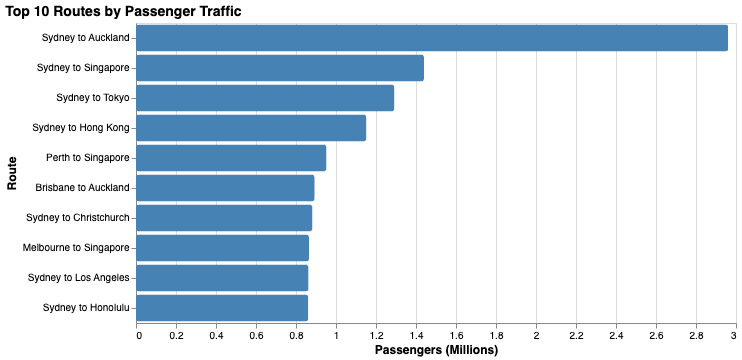

In [236]:
# bottom 10 chart for routes with the least passenger traffic
bottom_routes1 = traffic.tail(10).reset_index()
bottom_routes1.columns = ['route', 'passengers'] 
bottom_10_chart = alt.Chart(bottom_routes1).mark_bar(
    color='orange',
    cornerRadius=3
).encode(
    x=alt.X('passengers:Q', 
            title='Passengers (Thousands)',
            axis=alt.Axis(format='.0f', labelExpr='datum.value/1000')),
    y=alt.Y('route:N', 
            sort='x',  
            title='Route'),
    tooltip=[
        alt.Tooltip('route:N'),
        alt.Tooltip('passengers:Q', format=',.0f')
    ]
).properties(
    width=600,
    height=300,
    title='Bottom 10 Routes by Passenger Traffic'
).configure_axis(
    labelFontSize=10,
    titleFontSize=12
).configure_title(
    fontSize=14,
    anchor='start'
)
bottom_10_chart.show()

alt.Chart(...)

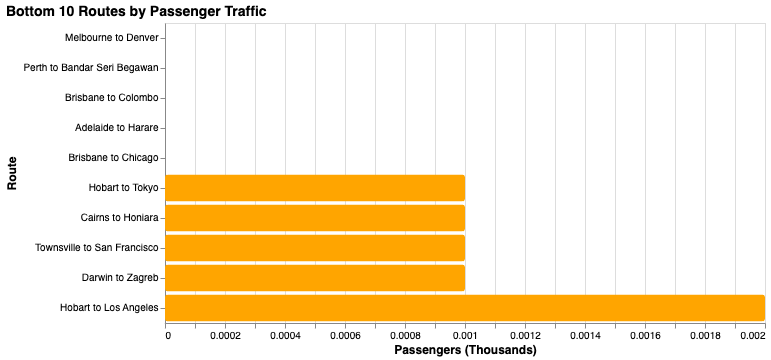

### a) Identify the most and least trafficked routes
- The bar charts show that the Sydney to Auckland route seems to be the most traveled with almost 3 million passengers total, whereas the Melbourne to Denver route is rarely used with 0 passengers. 

# PART 1b and 1c

## Are there any trends or growth patterns across different cities or regions?

In [217]:
# we can look at which regions are most popular with passengers
df['Country'].unique()

array(['New Zealand', 'Bahrain', 'India', 'Germany', 'UK', 'Oman',
       'Italy', 'Singapore', 'United Arab Emirates', 'Thailand',
       'Hong Kong', 'Solomon Islands', 'USA', 'Malaysia', 'Philippines',
       'Fiji', 'New Caledonia', 'Papua New Guinea', 'Vanuatu', 'Japan',
       'Canada', 'Brunei', 'Indonesia', 'Netherlands', 'Greece', 'China',
       'Yugoslavia', 'Sri Lanka', 'Cyprus', 'Mauritius', 'Nauru',
       'Tahiti', 'Zimbabwe', 'South Africa', 'Western Samoa', 'France',
       'Denmark', 'Cook Islands', 'American Samoa', 'Austria',
       'Argentina', 'Guam', 'Malta'], dtype=object)

In [218]:
# map each country to a region function
def region_mapping(country):
    if country in ['United States', 'USA', 'Canada']:
        return 'North America'
    elif country in ['United Kingdom', 'UK', 'France', 'Germany', 'Italy', 'Spain', 'Netherlands', 'Greece', 'Denmark', 'Austria', 'Malta', 'Cyprus', 'Yugoslavia']:
        return 'Europe'
    elif country in ['China', 'Japan', 'South Korea', 'India', 'Singapore', 'Thailand', 'Hong Kong', 'Malaysia', 'Philippines', 'Brunei', 'Indonesia', 'Sri Lanka']:
        return 'Asia'
    elif country in ['Brazil', 'Argentina']:
        return 'South America'
    elif country in ['South Africa', 'Nigeria', 'Zimbabwe', 'Mauritius']:
        return 'Africa'
    elif country in ['Bahrain', 'Oman', 'United Arab Emirates']:
        return 'Middle East'
    elif country in ['New Zealand', 'Fiji', 'Solomon Islands', 'Papua New Guinea', 'Vanuatu', 'New Caledonia', 'Cook Islands', 'American Samoa', 'Western Samoa', 'Tahiti', 'Nauru', 'Guam']:
        return 'Oceania/Pacific'
    else:
        return 'Other'

In [237]:
# apply the mapping to create a new column for destination region for each country
df['DestinationRegion'] = df['Country'].apply(region_mapping)
dest_trends = df.groupby(['Year', 'DestinationRegion'])['Passengers_Total'].sum().reset_index()

# altair bar chart for passenger traffic by destination region over time
destination_chart = alt.Chart(dest_trends).mark_bar().encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Passengers_Total:Q', title='Passengers'),
    color=alt.Color('DestinationRegion:N', 
                   title='Destination Region',
                   scale=alt.Scale(scheme='dark2')),
    tooltip=[
        alt.Tooltip('Year:O'),
        alt.Tooltip('DestinationRegion:N', title='Region'),
        alt.Tooltip('Passengers_Total:Q', format=',.0f', title='Passengers')
    ]
).properties(
    width=700,
    height=300,
    title='Passenger Traffic by Destination Region Over Time'
)

destination_chart.show()

alt.Chart(...)

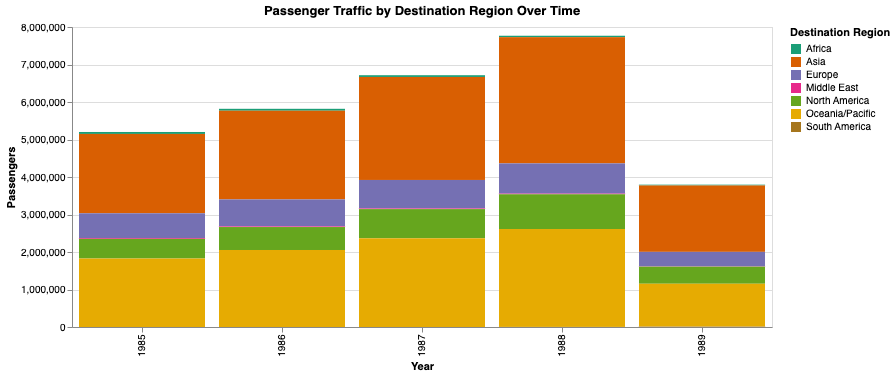

### b) Analyze trends and/or geographical patterns
- Asia is the region most traveled to from Austrailia, which could relate to tourism or students traveling for education. In 1989, there must have been a change/restriction in legislation or availability for for leaving Austrailia. 

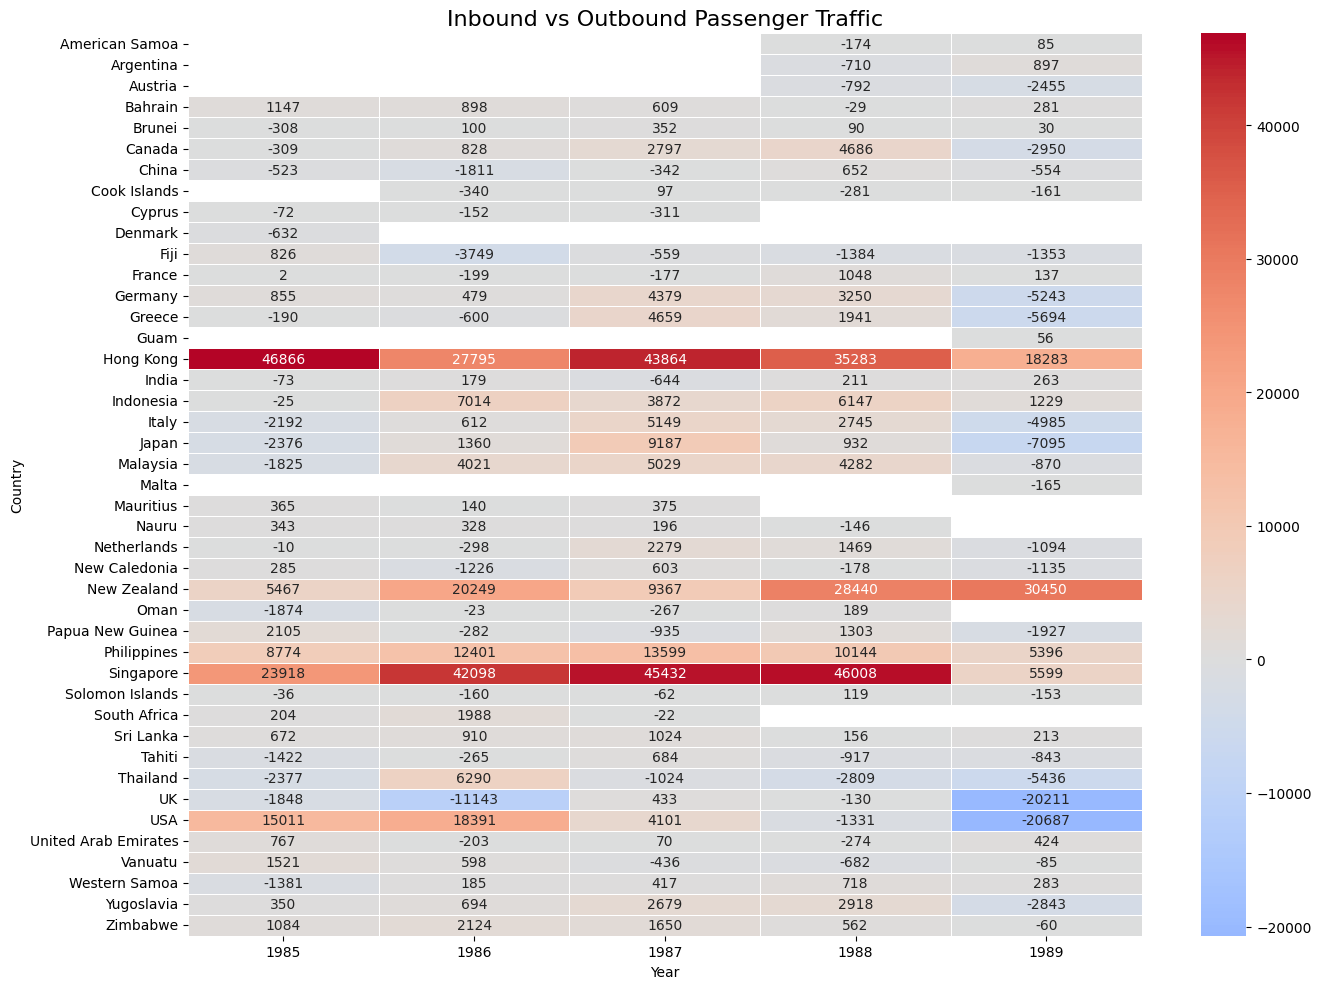

In [220]:
# inbound vs outbound traffic heatmap

# difference in passenger traffic between inbound and outbound (negative values indicate more outbound traffic/positive values indicate more inbound traffic)
diff = df.groupby(['Country', 'Year'])[['Passengers_In', 'Passengers_Out']].sum().reset_index()
diff['Passenger_Diff'] = diff['Passengers_In'] - diff['Passengers_Out']

# reshape into matrix format
heatmap_data = diff.pivot(index='Country', columns='Year', values='Passenger_Diff')
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0, linewidths=0.5, annot=True, fmt=".0f")

plt.title('Inbound vs Outbound Passenger Traffic', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

### b) Analyze trends and/or geographical patterns
- The red highlighted cells represent more people arriving from that country into Australia, and the blue means more people are leaving Austrailia to that country. White/neutral is balanced traffic.

- Lots of people traveled from Hong Kong and Singapore into Austrailia. On the other hand, the greatest number of people traveling out of the Austrailia went to the UK and the US in 1989.
Most of the time, travel appears to be balanced. Information could be interesting to see how populations change over time. 

# PART 2 - Predictive Model

In [221]:
# citypair column - using prophet for time series analysis
df['Route'] = df['AustralianPort'] + '-' + df['ForeignPort']

# convert to datetime object for prophet to work
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str).str.zfill(2) + '-01')

# first using the Sydney-Auckland route as an example citypair 
city_pair = 'Sydney-Auckland'
route_df = df[df['Route'] == city_pair]
model_df = route_df[['Date', 'Passengers_Total']].rename(columns={'Date': 'ds', 'Passengers_Total': 'y'})
model_df.head(12)

,ds,y
114,1985-01-01,48778
273,1985-02-01,43660
430,1985-03-01,54178
592,1985-04-01,45653
751,1985-05-01,45665
910,1985-06-01,40692
1070,1985-07-01,37626
1228,1985-08-01,41452
1387,1985-09-01,43783
1553,1985-10-01,44402


In [222]:
# initialize Prophet model + weekly seasonality because we are working with months 
model = Prophet(weekly_seasonality=True)
model.fit(model_df)

In [223]:
# predict the future year by generating future dates, starting with month start
future = model.make_future_dataframe(periods=12, freq='MS')  
predictions = model.predict(future)

# yhat: predicted value 
# yhat_lower: lower bound
# yhat_upper: upper bound

# dataframe that predicts passenger traffic for the start of each month
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,1985-01-01,50129.160855,44969.435887,55383.908811
1,1985-02-01,43991.764953,39108.607329,49539.730351
2,1985-03-01,50735.651825,45237.434068,56104.944176
3,1985-04-01,39003.619610,33996.163581,44453.498149
4,1985-05-01,41049.492864,36243.966960,46339.605634
...,...,...,...,...
61,1990-02-01,52304.278827,47469.988619,57645.463700
62,1990-03-01,54731.538525,49478.455963,60068.320959
63,1990-04-01,54534.961592,49171.720678,59813.676376
64,1990-05-01,47721.549643,42352.692508,52860.776799


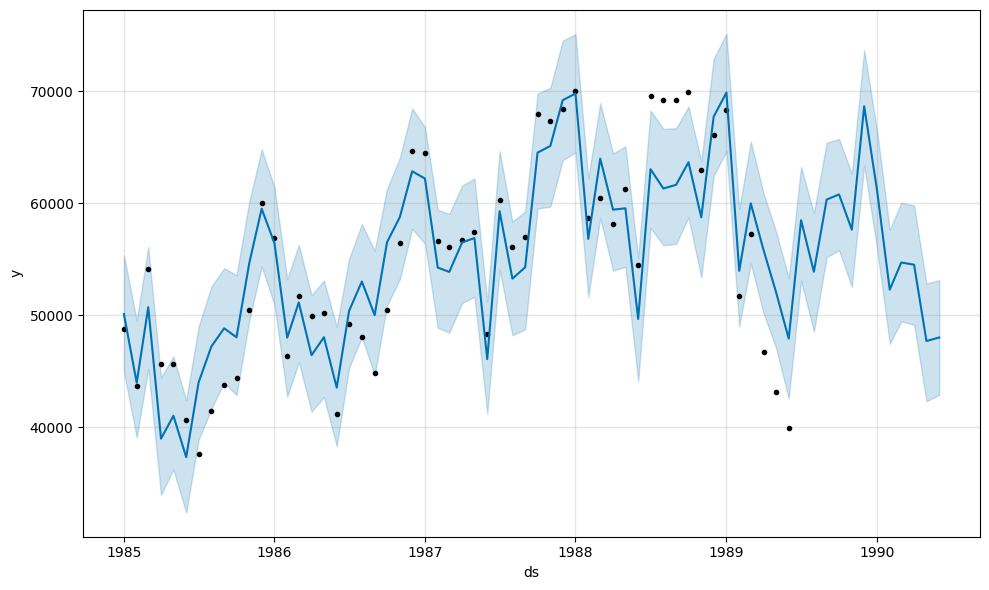

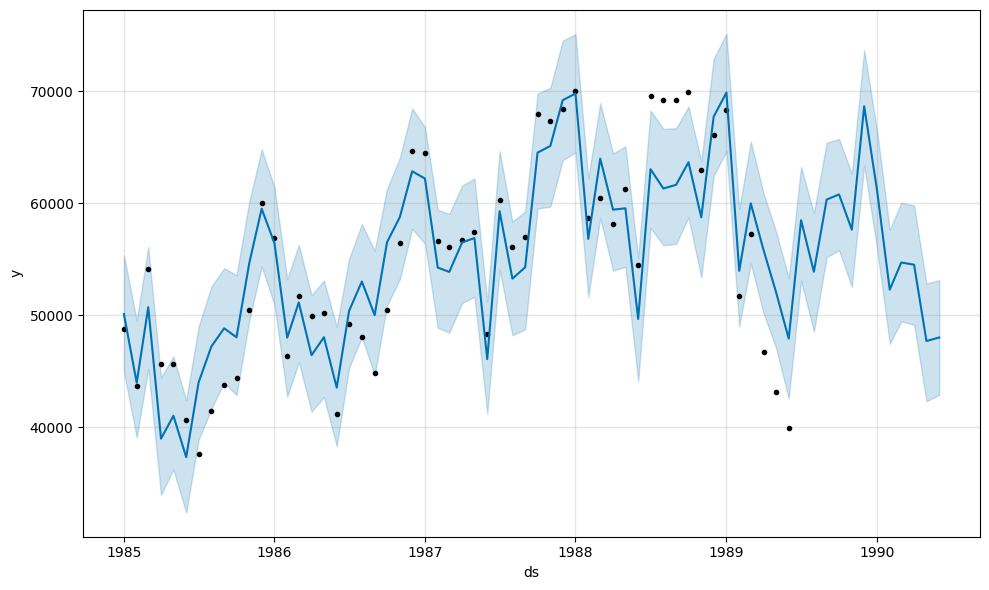

In [224]:
# plot the forecast with uncertainty intervals
model.plot(predictions, uncertainty=True)

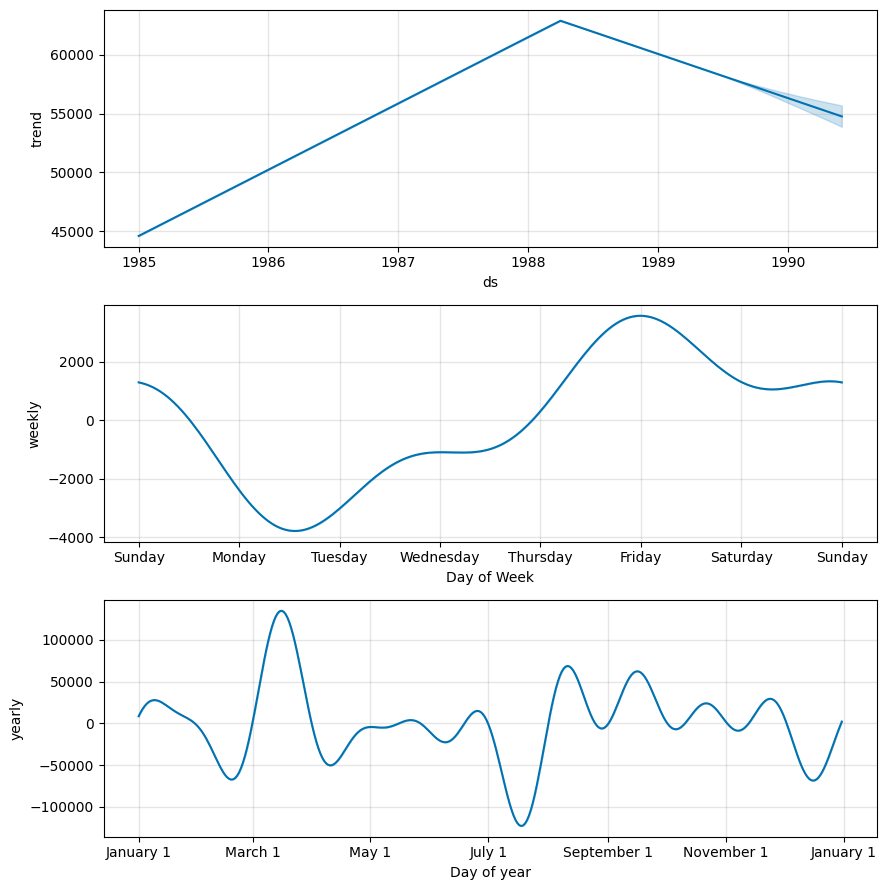

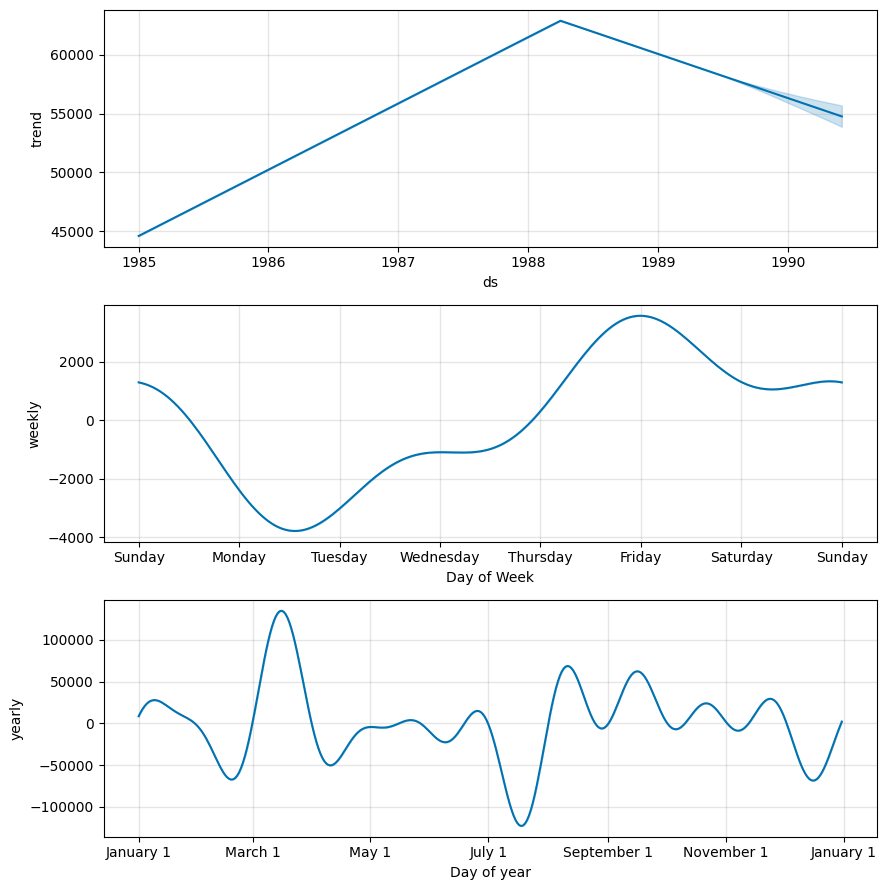

In [225]:
# dvive into more detail with the components of the predictions
model.plot_components(predictions)

In [226]:
# predictons for year 1990 for Sydney to Auckland route 
predictions_1990 = predictions[predictions['ds'].dt.year == 1990]
predictions_1990['yhat']

60    61237.930183
61    52304.278827
62    54731.538525
63    54534.961592
64    47721.549643
65    48034.656304
Name: yhat, dtype: float64

# PART 3

### a) Explain your model choices — why did you choose the elements you did
- I chose to use Prophet because it automatically handles the seasonal patterns found in traffic data like travel seasons and holiday spikes, while also having uncertainty intervals, which definetely helps with data as unpredictable as airline data. Prophet also has the ability to break down traffic data into compoenents, like trends, seasonality, and holidays, which make the model suitable for interpreting traffic patterns on different levels. 

In [227]:
# compare predictions with the original data
metric_df = predictions.set_index('ds')[['yhat']].join(model_df.set_index('ds').y).reset_index()

In [228]:
# drop rows with don't have actual future data in y column
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
49,1989-02-01,53987.817858,51697.0
50,1989-03-01,60012.131687,57288.0
51,1989-04-01,55840.995734,46747.0
52,1989-05-01,52128.230793,43203.0
53,1989-06-01,47932.198569,39950.0


In [229]:
# r-squared score: decently strong r2 value + indicates that the model explains a good amount of variance in the traffic
r2_score(metric_df.y, metric_df.yhat)

0.8032946503517555

In [230]:
# mean squared error: not the greatest value, but the passenger traffic data changes a lot throughout the months, so a higher MSE is expected
mean_squared_error(metric_df.y, metric_df.yhat)

16759904.434158308

In [231]:
# MAE: average magnitude of errors, shows that passeneger counts are off by an avg of 3.5k passengers per month
mean_absolute_error(metric_df.y, metric_df.yhat)

3335.553174516683

### b) Evaluate the model's performance & report the accuracy of the model
- The R2 score showed that the model explained a decent amount of variance in the passenger traffic data, indicating a good overall fit. However, the MAE was around 3,500 passengers per month, which might seem high but I believe it is expected due to the natural ups and downs in airline traffic. The MSE on the other hand was relatively large, likely because it penalizes large prediction errors more heavily, and there were big fluctuations in the data over the months. While the error values were not perfect, they do reflect the unpredictable nature of monthly travel data.

# PART 4

In [232]:
# finding the best routes with the most passenger traffic in the future
results = []

for route in df['Route'].unique():
    route_data = df[df['Route'] == route]

    # if the route has less than 2 data points, skip it
    if len(route_data) < 2:
        print(f"skipping {route}:{len(route_data)} data point(s).")
        continue  

    # creating model
    model_df = (route_data.assign(
                    Date=lambda x: pd.to_datetime(
                        x['Year'].astype(str) + '-' +
                        x['Month_num'].astype(str).str.zfill(2) + '-01'))
                .rename(columns={'Date': 'ds', 'Passengers_Total': 'y'})[['ds', 'y']])

    model = Prophet(interval_width=0.95)
    model.fit(model_df)

    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    # results df with route and forecasted passenger traffic for the next year 
    future_sum = forecast[forecast['ds'] > model_df['ds'].max()]['yhat'].sum()
    results.append({'Route': route, 'Forecast': future_sum})

results_df = pd.DataFrame(results)


skipping Melbourne-Mauritius:1 data point(s).
skipping Adelaide-Copenhagen:1 data point(s).
skipping Darwin-Copenhagen:1 data point(s).
skipping Melbourne-Copenhagen:1 data point(s).
skipping Perth-Copenhagen:1 data point(s).
skipping Sydney-Copenhagen:1 data point(s).
skipping Melbourne-Ljubljana:1 data point(s).
skipping Sydney-Ljubljana:1 data point(s).
skipping Brisbane-Colombo:1 data point(s).
skipping Adelaide-Harare:1 data point(s).
skipping Melbourne-Denver:1 data point(s).
skipping Darwin-Zagreb:1 data point(s).
skipping Brisbane-Zagreb:1 data point(s).
skipping Townsville-Zagreb:1 data point(s).
skipping Perth-Manila:1 data point(s).
skipping Cairns-Larnaca:1 data point(s).
skipping Sydney-Dunedin:1 data point(s).
skipping Townsville-Nadi:1 data point(s).
skipping Cairns-Honiara:1 data point(s).
skipping Townsville-San Francisco:1 data point(s).
skipping Perth-Port Moresby:1 data point(s).
skipping Townsville-Manila:1 data point(s).
skipping Hobart-Los Angeles:1 data point(s)

In [233]:
top_routes = results_df.sort_values('Forecast', ascending=False).head(10)
print(top_routes)


                   Route       Forecast
113      Sydney-Auckland  727288.549816
151         Sydney-Tokyo  522653.485564
150     Sydney-Singapore  398292.168856
127     Sydney-Hong Kong  338519.548919
128      Sydney-Honolulu  302080.769181
135   Sydney-Los Angeles  301625.807449
106      Perth-Singapore  297010.909497
9      Brisbane-Auckland  287144.831072
84   Melbourne-Singapore  248984.108653
53    Melbourne-Auckland  213736.188309


In [234]:
bottom_routes = results_df.sort_values('Forecast', ascending=True).head(10)
print(bottom_routes)


                             Route      Forecast
81             Melbourne-Port Vila -10504.367067
163                 Sydney-Seattle  -5359.449162
203               Brisbane-Jakarta  -4654.718512
92                    Perth-Bombay  -3577.340399
55   Melbourne-Bandar Seri Begawan  -3313.190227
115     Sydney-Bandar Seri Begawan  -2330.239778
167                  Sydney-Zagreb  -1477.290065
125               Sydney-Guangzhou  -1359.362650
270                 Sydney-Chicago   -566.074800
227              Cairns-Manchester   -553.532716


### a) Which routes should AeroConnect invest more in or scale back from? 
- AeroConnect should consider investing more in more popular routes like Sydney–Auckland, which show strong and consistent growth in predicted passenger traffic. These routes show rising demand and potential for higher return trips. In contrast, routes like Melbourne-Port Vila show declining trends in future forecasts, suggesting that AeroConnect may want to scale back or re-evaluate service on those connections.

### b) How can AeroConnect use this model going forward? 
- AeroConnect can use this forecasting model to predict monthly passenger traffic for each city pair. This helps them plan ahead for resource allocation, like scheduling aircraft, crew, and gate assignments. It can also support strategic decisions, like adding capacity on growing routes and reducing flights on declining ones. Over time, the model can be retrained with new data to improve accuracy and adapt to changes like holidays or global events.